In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [6]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [7]:
print(tf.__version__)

2.8.0


In [8]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/mimii_dg_bearing_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\mimii_dg_bearing_out


In [9]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1200


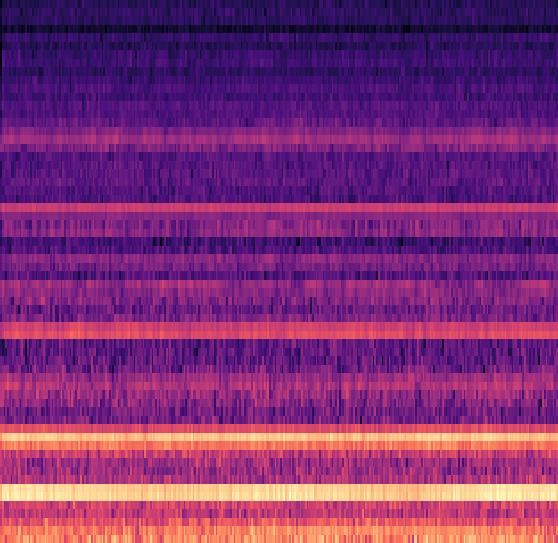

In [10]:
# image 1개 보기
# a_h = list(data_dir.glob('a_h/*'))
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[11]))

In [11]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [12]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [13]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    print("np.mean(loss): ", np.mean(loss),"np.std(loss): ", np.std(loss))
    return threshold

In [15]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [16]:
'''
2. Load training images
'''
data_path = "./dataset/mimii_dg_bearing_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/mimii_dg_bearing_out/normal_test"
x_test = create_training_data(data_path)

In [17]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, __ , __ = train_test_split(x_train, x_train, test_size=0.1, random_state=50)


In [18]:
print(X_train_split.shape)
print(X_test_split.shape)

(360, 224, 224)
(40, 224, 224)


In [19]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=8)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(X_train_split, X_train_split,
						  epochs=30,
						  #shuffle=True,
						  batch_size=16, verbose=1,
						  validation_data=(X_test_split, X_test_split))

Epoch 1/30
23/23 [==============================] - 1s 10ms/step - loss: 0.0197 - val_loss: 0.0074
Epoch 2/30
23/23 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 3/30
23/23 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/30
23/23 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/30
23/23 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/30
23/23 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/30
23/23 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/30
23/23 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/30
23/23 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/30
23/23 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 11/30
23/23 

In [20]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
Total params: 6,422,656
Trainable params: 6,422,656
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 50176)             6472704   
                                                                 
 reshape (Reshape)           (None, 224, 224)          0         
                                                                 
Total params: 6,472,704


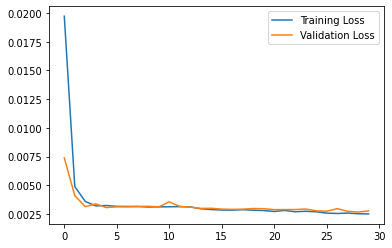

In [21]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
#plt.ylim([0, 0.15])
plt.show()

In [22]:
print("loss: ", np.mean(history.history["loss"]))
print("val_loss: ", np.mean(history.history["val_loss"]))

loss:  0.003531335659014682
val_loss:  0.0031751497959097226


In [23]:
# # save and load a mode
# autoencoder.save('./model_36cc/')
# autoencoder = keras.models.load_model('./model_36cc/')

In [24]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = Autoencoder(latent_dim=64 * 2)
# 	autoencoder = keras.models.load_model('./model_36cc/')

In [25]:
'''
4. Set threshold
'''
threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss Threshold: ", threshold)

np.mean(loss):  0.0024956617140185814 np.std(loss):  0.003267852291305781
Loss Threshold:  0.0057635140053243624


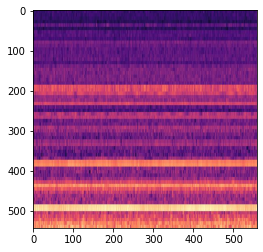

In [27]:
'''
5. Make an inference - abnormal 1
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = './dataset/mimii_dg_bearing_out/abnormal/section_00_source_test_anomaly_0003_vel_18.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [28]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

Loss is bigger than threshold 
 		  Sample Loss: 0.01317615620791912 
 		  Threshold: 0.0057635140053243624 


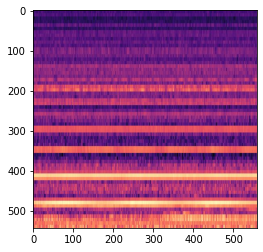

In [29]:
'''
5. Make an inference - abnormal 2
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = './dataset/mimii_dg_bearing_out/abnormal/section_00_source_test_anomaly_0016_vel_22.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [30]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

Loss is bigger than threshold 
 		  Sample Loss: 0.021419240161776543 
 		  Threshold: 0.0057635140053243624 


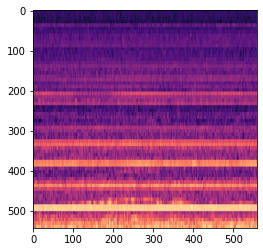

In [31]:
'''
5. Make an inference - normal 1
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = './dataset/mimii_dg_bearing_out/normal_test/section_00_source_train_normal_0951_vel_18.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [32]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

Loss is smaller than threshold 
 		  Sample Loss: 0.005489076487720013 
 		  Threshold: 0.0057635140053243624 


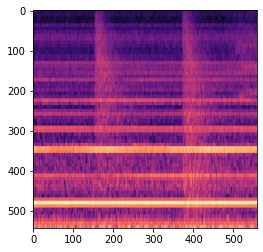

In [33]:
'''
5. Make an inference - abnormal 2
'''
# get statistics for each spectrogram
# file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
file = './dataset/mimii_dg_bearing_out/normal_test/section_00_source_train_normal_0453_vel_22.jpg'
sample = plt.imread(file)
plt.imshow(sample)
sample = pathlib.Path(file)
sample_loss = spectrogram_loss(autoencoder, sample)

In [34]:
if sample_loss > threshold:
	print(
		f'Loss is bigger than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')
else:
	print(
		f'Loss is smaller than threshold \n \
		  Sample Loss: {sample_loss} \n \
		  Threshold: {threshold} ')

Loss is smaller than threshold 
 		  Sample Loss: 0.005563974380493164 
 		  Threshold: 0.0057635140053243624 
